# Standford Dogs Dataset

Vamos a experimentar con una nueva base de datos. En este caso, hemos cogido un subconjunto de imágenes de la base de datos [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/). Esta es una base de datos que cuenta con 20.580 imágenes, divididas en 120 categorías. Sin embargo, en esta práctica, para simplificar el problema, hemos seleccionado, de estas 120 categorías, únicamente 10. Para la selección se han escogido aquellas clases que tienen un mayor número de imágenes.

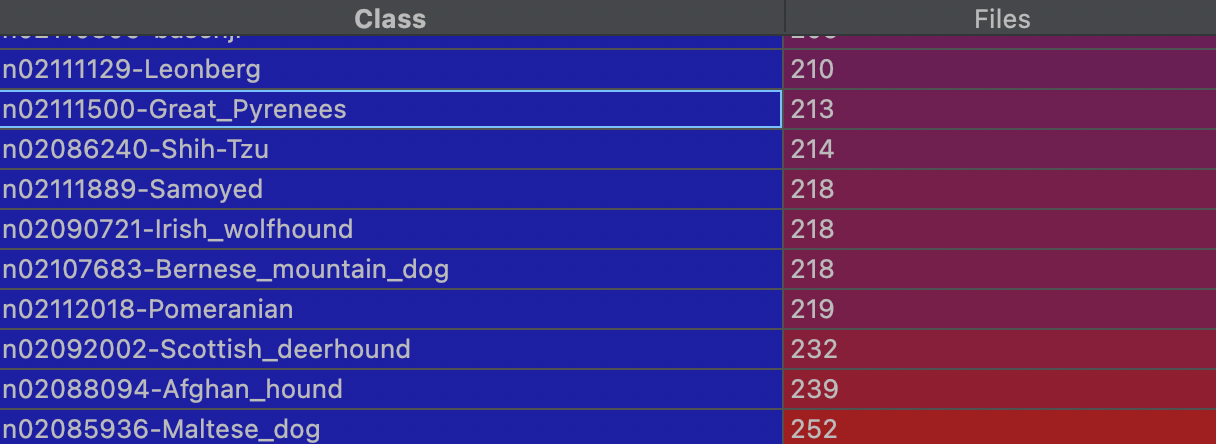

    A este subconjunto de imágenes podéis acceder en el siguiente enlace: https://drive.google.com/file/d/1hyO3J5XiclTqgMD_-ITPRJfVtOQ1GhY6/view?usp=share_link

Si trabajáis desde Google Colab podéis descargar el archivo directamente desde mi Drive con el siguiente snippet de código:

```

# Importamos librerías para interactuar con Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Nos autenticamos con nuestra cuenta de Google Drive para acceder a los datos
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Nos descargamos las imagenes que vamos a emplear
download = drive.CreateFile({'id': '1hyO3J5XiclTqgMD_-ITPRJfVtOQ1GhY6'})
download.GetContentFile('StanfordDogsDataset.zip')

```

Para descomprimir el archivo podéis usar el código:

```
with zipfile.ZipFile('StanfordDogsDataset.zip', 'r') as zip_ref:
    zip_ref.extractall('StanfordDogsDataset')
```

Con esto entrena varios modelos:

1. Haciendo uso de transferencia de conocimiento.
2. Haciendo uso de aumento de datos (prueba con varios tipos de transformación para ver si te afecta al rendimiento).
3. Haciendo uso de transferencia de conocimiento y aumento de datos.

In [1]:
import tensorflow as tf
from keras.src.utils import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import albumentations as A
from ImageDataAugmentor import ImageDataAugmentor
import numpy as np

IMG_SIZE = (256, 256, 3)
BATCH_SIZE = 32
RANDOM_STATE = 2_055
AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SOURCE_PATH = './StanfordDogsDataset'

In [2]:
train_dataset = image_dataset_from_directory(
    IMAGE_SOURCE_PATH,
    validation_split=.2,
    subset="training",
    seed=RANDOM_STATE,
    image_size=IMG_SIZE[:2],
    batch_size=BATCH_SIZE
)

validation_dataset = image_dataset_from_directory(
    IMAGE_SOURCE_PATH,
    validation_split=.2,
    subset="validation",
    seed=RANDOM_STATE,
    image_size=IMG_SIZE[:2],
    batch_size=BATCH_SIZE
)

train_ds = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Found 2233 files belonging to 10 classes.
Using 1787 files for training.
Found 2233 files belonging to 10 classes.
Using 446 files for validation.


In [16]:
def get_model_with_knowledge_transfer():
    model_constructor = tf.keras.applications.inception_v3.InceptionV3
    preprocess = tf.keras.applications.inception_v3.preprocess_input

    model_base = model_constructor(include_top=False, weights='imagenet', input_shape=IMG_SIZE)
    model_base.trainable = False

    input_layer = layers.Input(IMG_SIZE)
    preprocess_layer = preprocess(input_layer)
    base_layer = model_base(preprocess_layer, training=False)
    flatter_layer = layers.Flatten()(base_layer)
    output_layer = layers.Dense(10, activation="softmax")(flatter_layer)

    model_built = Model(inputs=[input_layer], outputs=[output_layer])

    return model_built

In [4]:
def get_model_no_knowledge_transfer():
    input_layer = layers.Input(shape=IMG_SIZE)

    layer_conv_1 = layers.Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding="same",
                                 activation="relu")(input_layer)
    layer_conv_2 = layers.Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding="same",
                                 activation="relu")(layer_conv_1)

    pool_1 = layers.MaxPool2D(pool_size=(2, 2))(layer_conv_2)

    layer_conv_3 = layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(2, 2), padding="same",
                                 activation="relu")(pool_1)

    pool_2 = layers.MaxPool2D(pool_size=(2, 2))(layer_conv_3)

    layer_conv_4 = layers.Conv2D(filters=12, kernel_size=(7, 7), strides=(1, 1), padding="same",
                                 activation="relu")(pool_2)
    layer_conv_5 = layers.Conv2D(filters=12, kernel_size=(7, 7), strides=(1, 1), padding="same",
                                 activation="relu")(layer_conv_4)

    global_avg = layers.GlobalAveragePooling2D()(layer_conv_5)

    dense_hidden_1 = layers.Dense(64, activation='relu')(global_avg)
    dense_hidden_2 = layers.Dense(32, activation='relu')(dense_hidden_1)

    dense_output = layers.Dense(10, activation='softmax')(dense_hidden_2)

    model = Model(inputs=[input_layer], outputs=[dense_output])

    return model

In [5]:
def train_model(model, train_data, validation_data):
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='./Practice02_NoAugmentation.h5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=True
    )

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_data, epochs=10, validation_data=validation_data,
                        callbacks=[model_checkpoint_callback], verbose=True)

    return history

In [24]:
def plot_losses(history):
    last_epoch_loss = history.history['loss'][-1]
    last_epoch_val_loss = history.history['val_loss'][-1]

    figure = plt.figure(figsize=(10, 8))

    axes = figure.add_subplot(1, 1, 1)

    axes.plot(history.history['loss'], color="#003B80", linestyle="dotted",
              label=f"loss entrenamiento {last_epoch_loss:.2f}")
    axes.plot(history.history['val_loss'], color="#003B80", label=f"loss validación {last_epoch_val_loss:.2f}")

    axes.set_xlabel('Época', color="#003B80", fontsize=14)
    axes.set_ylabel('Pérdidas', color="#003B80", fontsize=14)

    axes.set_title('Pérdidas durante el entrenamiento', fontsize=18)
    axes.set_facecolor('#F0F7FF')
    axes.legend(loc="best")
    axes.grid(visible=True, which='major', axis='both', color="#FFFFFF", linewidth=2)
    axes.set_axisbelow(True)
    axes.set_ylim(ymin=0, ymax=5.1)
    axes.yaxis.set_major_locator(MultipleLocator(0.3))

    return figure

In [7]:
model_no_augmentation = get_model_with_knowledge_transfer()
model_no_augmentation.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 256, 256, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 256, 256, 3)       0         
 da)                                                             
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 10)                737290

In [8]:
history_no_augmentation = train_model(model_no_augmentation, train_ds, validation_ds)

Epoch 1/10
56/56 [==============================] - ETA: 0s - loss: 1.7652 - accuracy: 0.8763
Epoch 1: val_accuracy improved from -inf to 0.93946, saving model to .\Practice02_NoAugmentation.h5


C:\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/56 [==============================] - 44s 720ms/step - loss: 1.7652 - accuracy: 0.8763 - val_loss: 1.7841 - val_accuracy: 0.9395
Epoch 2/10
56/56 [==============================] - ETA: 0s - loss: 0.5488 - accuracy: 0.9614
Epoch 2: val_accuracy did not improve from 0.93946
56/56 [==============================] - 39s 694ms/step - loss: 0.5488 - accuracy: 0.9614 - val_loss: 2.5829 - val_accuracy: 0.9013
Epoch 3/10
56/56 [==============================] - ETA: 0s - loss: 0.2447 - accuracy: 0.9810
Epoch 3: val_accuracy did not improve from 0.93946
56/56 [==============================] - 38s 682ms/step - loss: 0.2447 - accuracy: 0.9810 - val_loss: 1.8537 - val_accuracy: 0.9372
Epoch 4/10
56/56 [==============================] - ETA: 0s - loss: 0.2897 - accuracy: 0.9832
Epoch 4: val_accuracy did not improve from 0.93946
56/56 [==============================] - 36s 641ms/step - loss: 0.2897 - accuracy: 0.9832 - val_loss: 1.4460 - val_accuracy: 0.9350
Epoch 5/10
56/56 [===================

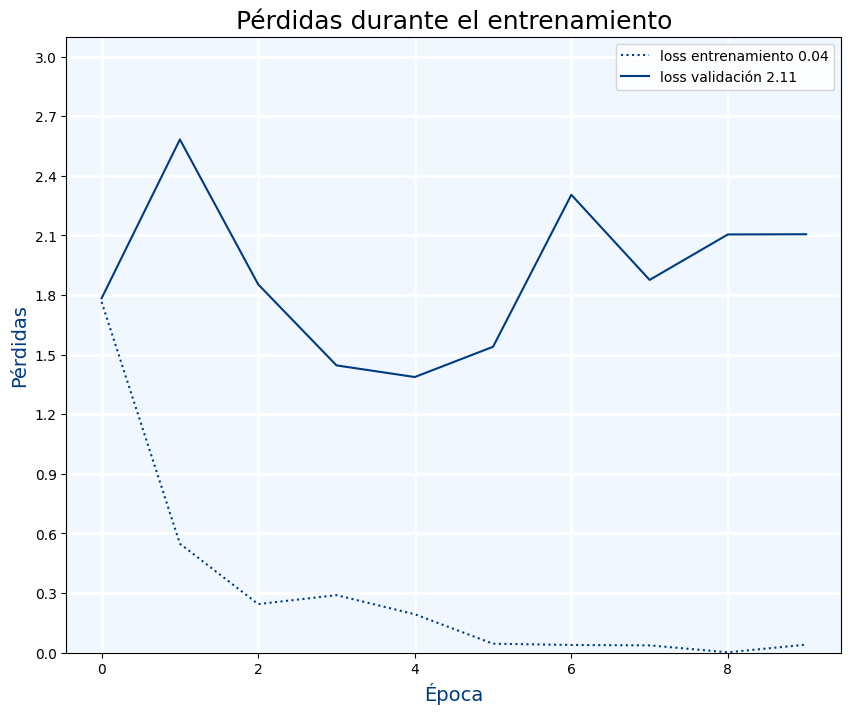

In [9]:
_ = plot_losses(history_no_augmentation)

# Data augmentation

In [10]:
def get_data_with_augmentation():
    # Implementamos la rutina de transformaciones
    transforms = A.Compose([
        A.HorizontalFlip(p=.5),
        A.VerticalFlip(p=.2),
        A.Rotate(limit=45, p=.8),
        A.RandomBrightnessContrast(brightness_limit=.8, contrast_limit=.8, p=.5),
        A.CLAHE(p=.5),
        A.Superpixels(p_replace=1, n_segments=1, p=.5)
    ])

    # Generador de datos de entrenamiento
    train_datagen = ImageDataAugmentor(
        augment=transforms,
        validation_split=0.2,
        seed=RANDOM_STATE
    )

    val_datagen = ImageDataAugmentor(
        validation_split=0.2,
        seed=RANDOM_STATE
    )

    train_dataset = train_datagen.flow_from_directory(
        IMAGE_SOURCE_PATH,
        subset="training",
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=True)

    # Dataset validación
    validation_dataset = val_datagen.flow_from_directory(
        IMAGE_SOURCE_PATH,
        subset="validation",
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=True
    )

    return train_dataset, validation_dataset

Found 1792 images belonging to 10 classes.
Found 441 images belonging to 10 classes.


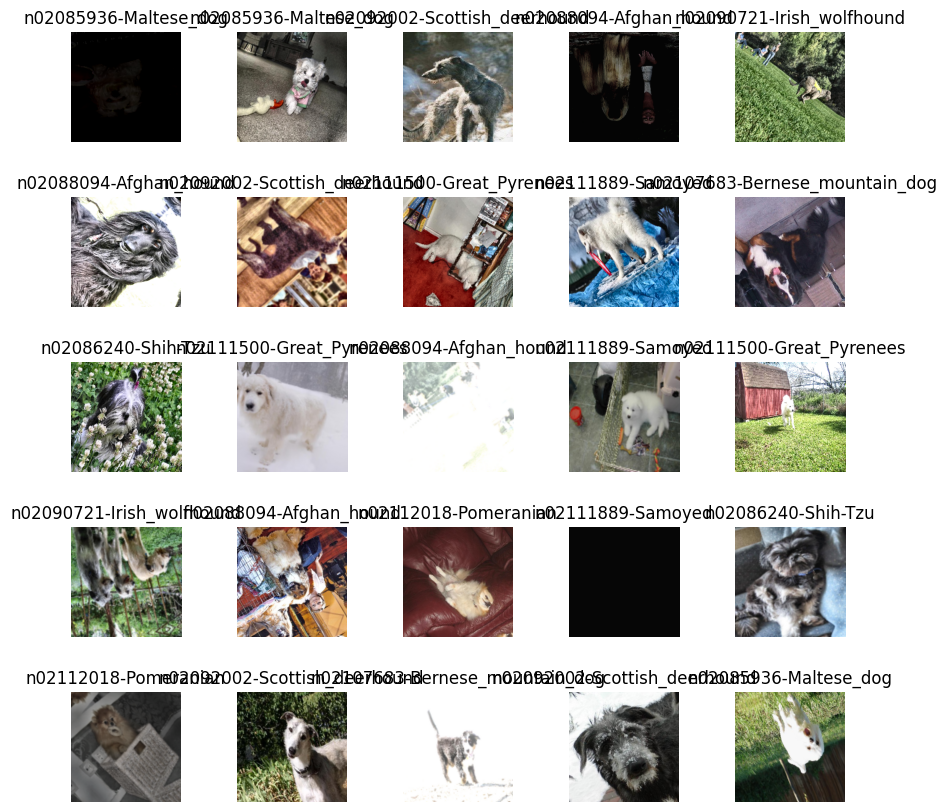

In [11]:
ds_train, ds_validation = get_data_with_augmentation()
ds_train.show_data()

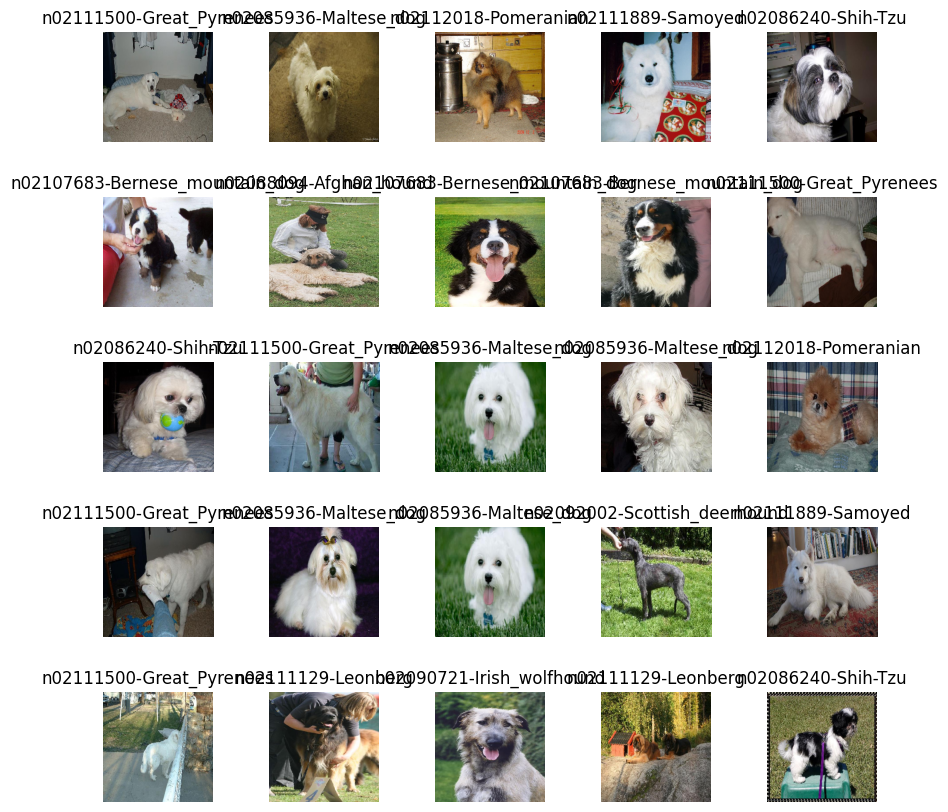

In [12]:
ds_validation.show_data()

In [13]:
model_data_aug = get_model_no_knowledge_transfer()
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='Practice02_WithAugmentation.h5',
                                                               monitor='val_accuracy', mode='max',
                                                               save_best_only=True,
                                                               verbose=1)

model_data_aug.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
train_samples = ds_train.n
validation_samples = ds_validation.n
history_data_aug = model_data_aug.fit(ds_train,
                                      steps_per_epoch=train_samples // BATCH_SIZE,
                                      epochs=10,
                                      validation_data=ds_validation,
                                      validation_steps=validation_samples // BATCH_SIZE,
                                      callbacks=[model_checkpoint_callback],
                                      verbose=1)

Epoch 1/10
56/56 [==============================] - ETA: 0s - loss: 2.3047 - accuracy: 0.1110
Epoch 1: val_accuracy improved from -inf to 0.11538, saving model to Practice02_WithAugmentation.h5
56/56 [==============================] - 18s 312ms/step - loss: 2.3047 - accuracy: 0.1110 - val_loss: 2.2895 - val_accuracy: 0.1154
Epoch 2/10
56/56 [==============================] - ETA: 0s - loss: 2.2963 - accuracy: 0.1172
Epoch 2: val_accuracy improved from 0.11538 to 0.13462, saving model to Practice02_WithAugmentation.h5
56/56 [==============================] - 17s 300ms/step - loss: 2.2963 - accuracy: 0.1172 - val_loss: 2.2808 - val_accuracy: 0.1346
Epoch 3/10
56/56 [==============================] - ETA: 0s - loss: 2.2917 - accuracy: 0.1367
Epoch 3: val_accuracy did not improve from 0.13462
56/56 [==============================] - 16s 290ms/step - loss: 2.2917 - accuracy: 0.1367 - val_loss: 2.2765 - val_accuracy: 0.0986
Epoch 4/10
56/56 [==============================] - ETA: 0s - loss: 

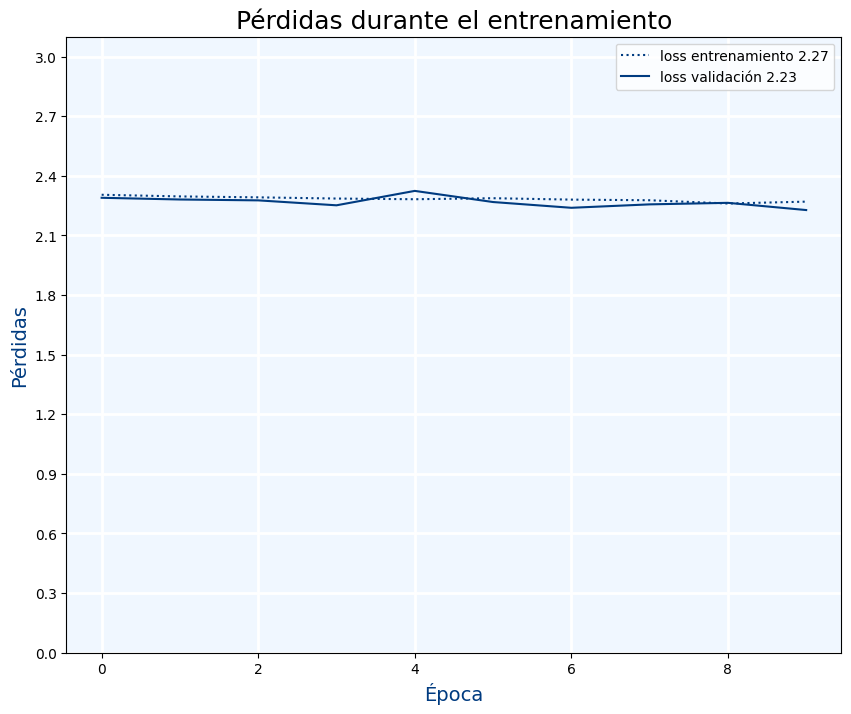

In [14]:
_ = plot_losses(history_data_aug)

# Knowledge transfer and data augmentation

In [20]:
model_transfer_aug = get_model_with_knowledge_transfer()
# model_transfer_aug.summary()

In [21]:
ds_knowledge_aug_train, ds_knowledge_aug_validation = get_data_with_augmentation()

Found 1792 images belonging to 10 classes.
Found 441 images belonging to 10 classes.


In [22]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='Practice02_TransferAugmentation.h5',
                                                               monitor='val_accuracy', mode='max',
                                                               save_best_only=True, verbose=1)

model_transfer_aug.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
train_samples = ds_knowledge_aug_train.n
validation_samples = ds_knowledge_aug_validation.n

history_transfer_aug = model_transfer_aug.fit(ds_knowledge_aug_train,
                                              steps_per_epoch=train_samples // BATCH_SIZE,
                                              epochs=10,
                                              validation_data=ds_knowledge_aug_validation,
                                              validation_steps=validation_samples // BATCH_SIZE,
                                              callbacks=[model_checkpoint_callback],
                                              verbose=1)

Epoch 1/10
56/56 [==============================] - ETA: 0s - loss: 6.3276 - accuracy: 0.6016
Epoch 1: val_accuracy improved from -inf to 0.91106, saving model to Practice02_TransferAugmentation.h5
56/56 [==============================] - 36s 611ms/step - loss: 6.3276 - accuracy: 0.6016 - val_loss: 1.0591 - val_accuracy: 0.9111
Epoch 2/10
56/56 [==============================] - ETA: 0s - loss: 4.0968 - accuracy: 0.7020
Epoch 2: val_accuracy improved from 0.91106 to 0.91198, saving model to Practice02_TransferAugmentation.h5
56/56 [==============================] - 34s 600ms/step - loss: 4.0968 - accuracy: 0.7020 - val_loss: 1.4693 - val_accuracy: 0.9120
Epoch 3/10
56/56 [==============================] - ETA: 0s - loss: 5.0575 - accuracy: 0.6842
Epoch 3: val_accuracy did not improve from 0.91198
56/56 [==============================] - 33s 592ms/step - loss: 5.0575 - accuracy: 0.6842 - val_loss: 2.9376 - val_accuracy: 0.8606
Epoch 4/10
56/56 [==============================] - ETA: 0s 

In [26]:
history_transfer_aug.history['accuracy']

[0.6015625,
 0.7020089030265808,
 0.6841517686843872,
 0.7103794813156128,
 0.7421875,
 0.7421875,
 0.7377232313156128,
 0.7594866156578064,
 0.7589285969734192,
 0.7672991156578064]

In [27]:
history_transfer_aug.history['val_accuracy']

[0.911057710647583,
 0.9119804501533508,
 0.8606356978416443,
 0.9339853525161743,
 0.8997554779052734,
 0.9413203001022339,
 0.9168704152107239,
 0.9364303350448608,
 0.9339853525161743,
 0.9339853525161743]

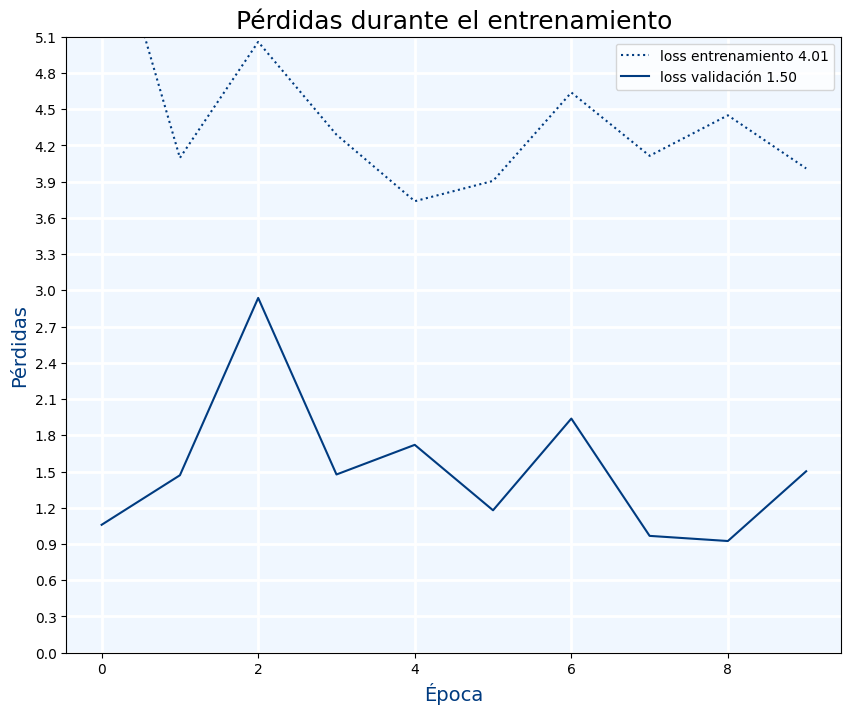

In [25]:
_ = plot_losses(history_transfer_aug)